# Comparing the data produced by Marilyn Ferland to the obsflow output

## Load and display Marilyn's extract data

In [ ]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

mf_dir = Path('/scen3/braun/data/obs_synthese23/data_marilyn/data/')
data_mf = ['AHCCD/months/mean/AHCCD_gen3_day_temperature_monthly_temp_mean.zarr', 'ERA5-LAND/months/mean/ECMWF_ERA5-Land_monthly_temp_mean.zarr', 'RDRS/months/mean/GouvCan_RDRS_monthly_temp_mean.zarr']

for d in data_mf:
    ds = xr.open_dataset(mf_dir / d, engine='zarr')
    #display(f'{d.split("/")[0]} Marilyn', ds)
    if 'AHCCD' in d: continue
    plt.figure()
    display(f'{d.split("/")[0]} Marilyn', ds.tg_mean.isel(time=0).plot(x='lon', y='lat'))
    plt.show()

## Load and display obsflow extracted data

In [ ]:
# load data extracted from obsflow
import xscen as xs

pcat = xs.ProjectCatalog('/scen3/braun/data/obs_synthese23/pcat_obs.json')
#display(pcat.df)
ds_dict = pcat.search(processing_level='extracted').to_dataset_dict()

for ds_id, ds_in in sorted(ds_dict.items()):
    if 'MRCC' in ds_id: continue
    if 'AHCCD' in ds_id:
       display(ds_id, ds_in)
    else:
        plt.figure()
        display(f'{ds_id.split(".")[0]} obsflow', ds_in.tas.isel(time=0).plot(x='lon', y='lat'))
        plt.show()


## Compare the data produced with obsflow to the data generated by Marilyn Ferland (monthly, seasonal averages)

In [ ]:
import xarray as xr
from pathlib import Path
from clisops.core.subset import subset_bbox
import matplotlib.pyplot as plt
import xscen as xs
import random

# trying to find the right data
#ds = xr.open_dataset('/scen3/braun/data/obs_synthese23/data_marilyn/data/RDRS/RDRS_qc_data.zarr', engine='zarr')
# ds = xr.open_dataset('/scen3/braun/data/obs_synthese23/data_marilyn/data/ERA5-LAND/era5_land_qc_data.nc')
# ds = xr.open_dataset('/scen3/braun/data/obs_synthese23/data_marilyn/data/ERA5-LAND/months/mean/ERA5_LAND_mean_temperature_yearly_JAN.zarr', engine='zarr')
# ds = xr.open_dataset('/scen3/braun/data/obs_synthese23/data_marilyn/data/RDRS/months/mean/RDRS_mean_temperature_yearly_JUN.zarr', engine='zarr')
# ds

mf_dir = Path('/scen3/braun/data/obs_synthese23/data_marilyn/data/')
data_mf = {'monthly' : ['AHCCD/months/mean/AHCCD_gen3_day_temperature_monthly_temp_mean.zarr', 'ERA5-LAND/months/mean/ECMWF_ERA5-Land_monthly_temp_mean.zarr', 'RDRS/months/mean/GouvCan_RDRS_monthly_temp_mean.zarr'], 
           'seasonal': ['AHCCD/seasons/mean/AHCCD_gen3_day_temperature_seasonal_temp_mean.zarr', 'ERA5-LAND/seasons/mean/ECMWF_ERA5-Land_seasonal_temp_mean.zarr', 'RDRS/seasons/mean/GouvCan_RDRS_seasonal_temp_mean.zarr']}
data_of = ['GovCan_AHCCD_CAN.Quebec.extracted.D',  'ECMWF_ERA5-Land_NAM.Quebec.extracted.D', 'GovCan_RDRS_NAM.Quebec.extracted.D']
tmp_agg = {'monthly': 'MS', 'seasonal': 'QS-DEC'}
#tmp_res = 'seasonal'

pcat = xs.ProjectCatalog('/scen3/braun/data/obs_synthese23/pcat_obs.json')
#display(pcat.df)
ds_dict = pcat.search(processing_level='extracted').to_dataset_dict()

for tmp_res in ['monthly', 'seasonal']:
    # iterate over both datasets
    for mf, of in zip(data_mf[tmp_res], data_of):
        if 'AHCCD' in mf: continue
        my_bbox = {'lon_bnds': [-75, -71], 'lat_bnds' : [47, 51]}
        ds_mf = xr.open_dataset(mf_dir / mf, engine='zarr')
        ds_mf = subset_bbox(ds_mf, **my_bbox) 
        display(f'{of.split(".")[0]} {tmp_res} Marilyn', ds_mf)
        ds_of = ds_dict[of].sel(time=slice('2022-08-31')).resample(time=tmp_agg[tmp_res]).mean()
        ds_of = subset_bbox(ds_of, **my_bbox)
        display(f'{of.split(".")[0]} {tmp_res} obsflow', ds_of.compute())
        
        print('Display the datasets and their difference at 3 random times')
        diff = ds_mf.tg_mean - ds_of.tas
        for t in [random.randint(0, ds_mf.time.size) for _ in range(3)]:
            fig, ax = plt.subplots(1, 3, figsize=(18, 4))
            ds_mf.tg_mean.isel(time=t).plot(ax=ax[0], x='lon', y='lat')
            ax[0].set_title(f'Marilyn {tmp_res} {ds_mf.time[t].dt.strftime("%Y-%m-%d").item()}')
            ds_of.tas.isel(time=t).plot(ax=ax[1], x='lon', y='lat')
            ax[1].set_title(f'obsflow {tmp_res} {ds_of.time[t].dt.strftime("%Y-%m-%d").item()}')
            diff.isel(time=t).plot(ax=ax[2], x='lon', y='lat', cmap='RdBu_r')
            ax[2].set_title(f'Marilyn-obsflow {ds_mf.time[t].dt.strftime("%Y-%m-%d").item()}')
            plt.show()

## Compare the data produced with obsflow to the data generated by Marilyn Ferland (monthly, seasonal trends/linregress)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


'GovCan_RDRS_NAM year Marilyn'

<xarray.Dataset>
Dimensions:          (rlat: 56, rlon: 55)
Coordinates:
  * rlat             (rlat) float32 -4.95 -4.86 -4.77 ... -0.18 -0.09 -1.107e-07
  * rlon             (rlon) float32 370.1 370.1 370.2 ... 374.7 374.8 374.9
    rotated_pole     float32 9.969e+36
Data variables:
    tg_mean_pvalue   (rlat, rlon) float64 0.002374 0.002508 ... 0.006075
    tg_mean_std_err  (rlat, rlon) float64 0.0223 0.02214 ... 0.0254 0.02529
    tg_mean_trend    (rlat, rlon) float64 0.07452 0.07351 ... 0.07499 0.07506
    tn_mean_pvalue   (rlat, rlon) float64 0.003505 0.003483 ... 0.002721
    tn_mean_std_err  (rlat, rlon) float64 0.02378 0.02364 ... 0.02747 0.02747
    tn_mean_trend    (rlat, rlon) float64 0.07584 0.07543 ... 0.09078 0.09033
    tx_mean_pvalue   (rlat, rlon) float64 0.001488 0.00169 ... 0.0162 0.0156
    tx_mean_std_err  (rlat, rlon) float64 0.02115 0.02104 ... 0.02393 0.02369
    tx_mean_trend    (rlat, rlon) float64 0.0745 0.07309 ... 0.06124 0.06099
Attributes:
    description:  Linear least-squares regression for annual values
    end_date:     2010-12-31
    start_date:   1981-01-01
    units:        (unit of variables)/year

'GovCan_RDRS_NAM year obsflow'

<xarray.Dataset>
Dimensions:                  (period: 2, year: 1, rlat: 56, rlon: 55,
                              linreg_param: 6)
Coordinates:
    lat                      (rlat, rlon) float32 dask.array<chunksize=(56, 55), meta=np.ndarray>
  * linreg_param             (linreg_param) <U16 'slope' ... 'intercept_stderr'
    lon                      (rlat, rlon) float32 dask.array<chunksize=(56, 55), meta=np.ndarray>
  * period                   (period) <U9 '1981-2010' '1991-2018'
  * rlat                     (rlat) float32 -4.95 -4.86 ... -0.09 -1.107e-07
  * rlon                     (rlon) float32 370.1 370.1 370.2 ... 374.8 374.9
    rotated_pole             float32 9.969e+36
  * year                     (year) <U3 'ANN'
Data variables: (12/15)
    tg_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    tg_mean_clim_mean        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_mean_clim_std         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_std_clim-total        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tn_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    ...                       ...
    tn_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    tx_mean_clim_mean        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_mean_clim_std         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_std_clim-total        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-01-01 00:00:00
    cat:date_start:          1980-01-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    realm:                   atmos
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1

Display the datasets and their difference


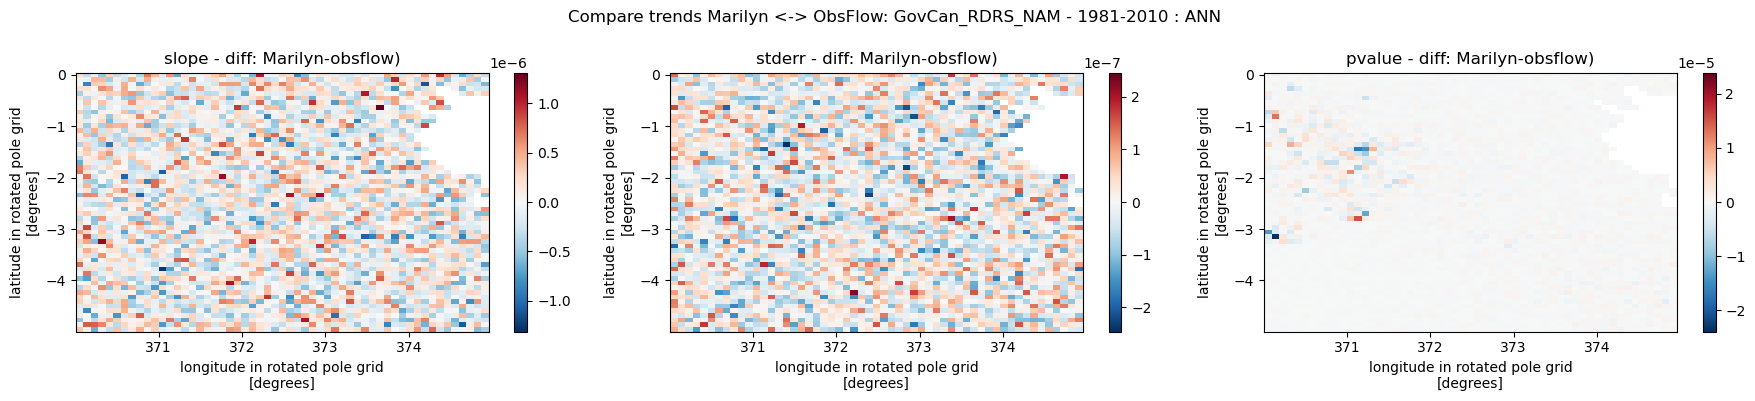

'GovCan_RDRS_NAM year Marilyn'

<xarray.Dataset>
Dimensions:          (rlat: 56, rlon: 55)
Coordinates:
    lat              (rlat, rlon) float32 ...
  * rlat             (rlat) float32 -4.95 -4.86 -4.77 ... -0.18 -0.09 -1.107e-07
  * rlon             (rlon) float32 370.1 370.1 370.2 ... 374.7 374.8 374.9
    rotated_pole     float32 9.969e+36
Data variables:
    lon              (rlat, rlon) float32 -75.97 -75.83 -75.69 ... -65.71 -65.56
    tg_mean_pvalue   (rlat, rlon) float64 0.09182 0.09355 ... 0.1413 0.1434
    tg_mean_std_err  (rlat, rlon) float64 0.02582 0.02562 ... 0.02821 0.02818
    tg_mean_trend    (rlat, rlon) float64 0.0452 0.0446 ... 0.04281 0.04252
    tn_mean_pvalue   (rlat, rlon) float64 0.06113 0.06583 ... 0.1139 0.114
    tn_mean_std_err  (rlat, rlon) float64 0.02692 0.02686 ... 0.0304 0.03036
    tn_mean_trend    (rlat, rlon) float64 0.05269 0.05158 ... 0.04972 0.04966
    tx_mean_pvalue   (rlat, rlon) float64 0.1052 0.1026 ... 0.1686 0.1798
    tx_mean_std_err  (rlat, rlon) float64 0.02512 0.02492 ... 0.0266 0.02647
    tx_mean_trend    (rlat, rlon) float64 0.04217 0.04216 ... 0.03766 0.03649

'GovCan_RDRS_NAM year obsflow'

<xarray.Dataset>
Dimensions:                  (period: 2, year: 1, rlat: 56, rlon: 55,
                              linreg_param: 6)
Coordinates:
    lat                      (rlat, rlon) float32 dask.array<chunksize=(56, 55), meta=np.ndarray>
  * linreg_param             (linreg_param) <U16 'slope' ... 'intercept_stderr'
    lon                      (rlat, rlon) float32 dask.array<chunksize=(56, 55), meta=np.ndarray>
  * period                   (period) <U9 '1981-2010' '1991-2018'
  * rlat                     (rlat) float32 -4.95 -4.86 ... -0.09 -1.107e-07
  * rlon                     (rlon) float32 370.1 370.1 370.2 ... 374.8 374.9
    rotated_pole             float32 9.969e+36
  * year                     (year) <U3 'ANN'
Data variables: (12/15)
    tg_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    tg_mean_clim_mean        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_mean_clim_std         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_std_clim-total        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tg_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tn_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    ...                       ...
    tn_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_mean_clim_linregress  (period, year, rlat, rlon, linreg_param) float32 dask.array<chunksize=(2, 1, 16, 21, 6), meta=np.ndarray>
    tx_mean_clim_mean        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_mean_clim_std         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_std_clim-total        (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
    tx_std_clim_mean         (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 16, 21), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-01-01 00:00:00
    cat:date_start:          1980-01-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    realm:                   atmos
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1

Display the datasets and their difference


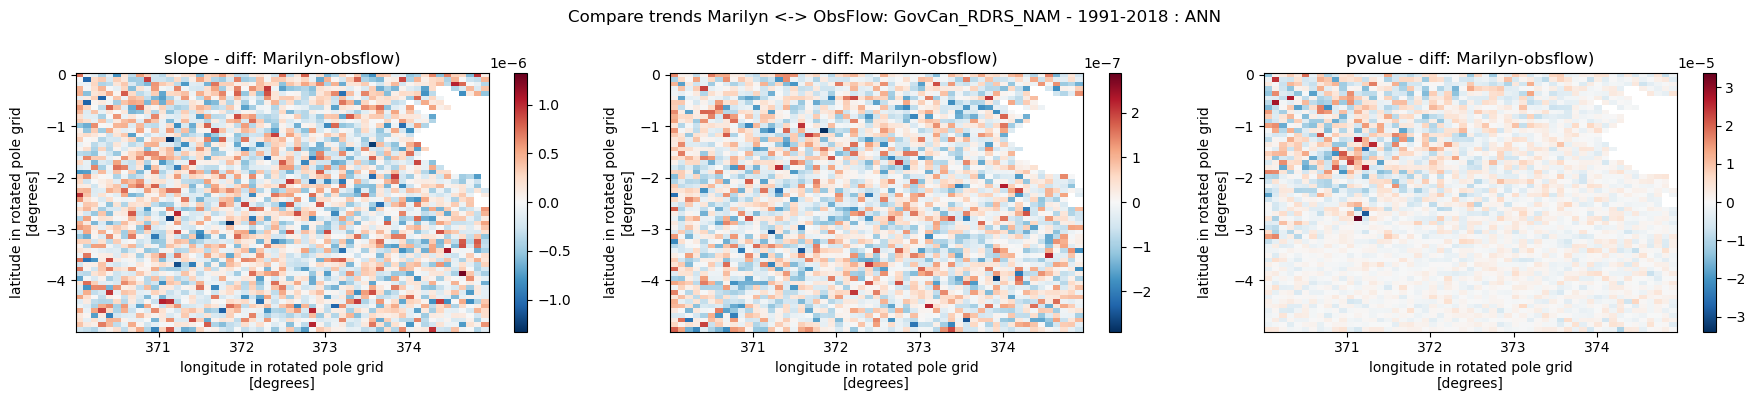

In [100]:
import xarray as xr
from pathlib import Path
from clisops.core.subset import subset_bbox
import matplotlib.pyplot as plt
import xscen as xs
import random


mf_dir = Path('/scen3/braun/data/obs_synthese23/data_marilyn/data/')
# things to iterate over
data_mf = {'month' : ['AHCCD/months/stats_trend/AHCCD_gen3_stats_trend_{period}.zarr', 'ERA5-LAND/months/stats_trend/ECMWF_ERA5-Land_monthly_trend_{period}.zarr',
                        'RDRS/months/stats_trend/GouvCan_RDRS_monthly_trend_{period}.zarr'], 
           'season': ['AHCCD/seasons/stats_trend/AHCCD_gen3_stats_trend_{period}.zarr', 'ERA5-LAND/seasons/stats_trend/ECMWF_ERA5-Land_seasonal_trend_{period}.zarr',
                        'RDRS/seasons/stats_trend/GouvCan_RDRS_seasonal_trend_{period}.zarr'],
           'year': ['AHCCD/annual/stats_trend/AHCCD_gen3_stats_trend_admin_reg_{period}.nc', 'ERA5-LAND/annual/stats_trend/ECMWF_ERA5_annual_trend_{period}.zarr',
                      'RDRS/annual/stats_trend/GouvCan_RDRS_annual_trend_{period}.zarr']}
data_of = {'month': ['GovCan_AHCCD_NAM.Quebec.climatology.MS', 'ECMWF_ERA5-Land_NAM.Quebec.climatology.MS', 'GovCan_RDRS_NAM.Quebec.climatology.MS'],
           'season': ['GovCan_AHCCD_NAM.Quebec.climatology.QS-DEC', 'ECMWF_ERA5-Land_NAM.Quebec.climatology.QS-DEC', 'GovCan_RDRS_NAM.Quebec.climatology.QS-DEC'],
           'year': ['GovCan_AHCCD_NAM.Quebec.climatology.AS-JAN', 'ECMWF_ERA5-Land_NAM.Quebec.climatology.AS-JAN', 'GovCan_RDRS_NAM.Quebec.climatology.AS-JAN']}
tmp_agg = {'monthly': 'MS', 'seasonal': 'QS-DEC', 'annual': 'AS-JAN'}
params ={'slope': 'trend', 'stderr': 'std_err', 'pvalue': 'pvalue'}
periods = ['1951-1980', '1961-1990', '1971-2000', '1981-2010', '1991-2020']
periods = ['1981-2010', '1991-2018']
periods_djf = {'1951-1980': '1950-1979', '1961-1990': '1960-1989', '1971-2000': '1970-1999', '1981-2010': '1980-2009', '1991-2020': '1990-2019', '1991-2018': '1990-2017'}
#tmp_res = 'seasonal'

pcat = xs.ProjectCatalog('/scen3/braun/data/obs_synthese23/pcat_obs.json')
# display(pcat.df)
ds_dict = pcat.search(processing_level='climatology').to_dataset_dict()
# for name, ds in sorted(ds_dict.items()): print(name)    

for period in periods:
    for tmp_res in ['year']:  # ['month', 'season']:  #['monthly', 'seasonal']:
    #     # iterate over both datasets
        for mf, of in zip(data_mf[tmp_res], data_of[tmp_res]):
            if any(s for s in ['AHCCD', 'ERA5'] if s in mf): continue
            
            # Deal with inconsistency in Marilyn's data
            if tmp_res == 'year' and period == '1991-2020':
                mf = mf.replace('ERA5_', 'ERA5-Land_')
            mf_period = period.replace('-', '_')
            if tmp_res == 'season':
                mf_period = mf_period[:3] + '0' + mf_period[4:]
            # print(mf_period)
            
            # get the data
            ds_mf = xr.open_dataset(mf_dir / mf.format(period=mf_period), engine='zarr')
            #display(f'{of.split(".")[0]} {tmp_res} Marilyn', ds_mf)
            ds_of = ds_dict[of]
            #display(f'{of.split(".")[0]} {tmp_res} obsflow', ds_of)
            # lat/lon have been removed in RDRS so we can't subset on them
            if 'RDRS' in mf:
                ds_mf = ds_mf.where((ds_mf.rlat > -5) & (ds_mf.rlat < 0) & (ds_mf.rlon > 370) & (ds_mf.rlon < 375) , drop=True)
                ds_of = ds_of.where((ds_of.rlat > -5) & (ds_of.rlat < 0) & (ds_of.rlon > 370) & (ds_of.rlon < 375) , drop=True)
                x_coord, y_coord = 'rlon', 'rlat'
            else:
                my_bbox = {'lon_bnds': [-75, -71], 'lat_bnds' : [47, 51]}
                ds_mf = subset_bbox(ds_mf, **my_bbox) 
                ds_of = subset_bbox(ds_dict[of], **my_bbox)
                x_coord, y_coord = 'lon', 'lat'
                
            display(f'{of.split(".")[0]} {tmp_res} Marilyn', ds_mf)
            display(f'{of.split(".")[0]} {tmp_res} obsflow', ds_of)
            
            # change period when seasons were taken from on year earlier
            period = [periods_djf[period] if tmp_res == 'season' else period][0]
            
            print('Display the datasets and their difference')
            for t, tmp in enumerate(ds_of[tmp_res].values, start=1):
                if tmp_res != 'season':
                    rows, cols = (1, 3)  
                    figsize_y = 4
                    title_pos = 0.99 #1.02
                else:
                    rows, cols = (3, 3)
                    figsize_y = 14
                    title_pos = 0.99
                fig, ax = plt.subplots(rows, cols, figsize=(18, figsize_y))
                if tmp_res != 'season': ax = ax.reshape(1,3)
                for p, param in enumerate(params.keys()):
                    # fix inconsistency issues in Marilyn's data
                    if tmp_res == 'month':
                        my_sel = {tmp_res: t}
                    if tmp_res == 'season':
                        my_sel = {tmp_res: tmp}
                    if tmp_res == 'year':
                        my_sel = {}
                    if tmp_res == 'season':
                        ds_mf[f'tg_mean_{params[param]}'].sel(my_sel).plot(ax=ax[rows-3,p], x=x_coord, y=y_coord)
                        ax[rows-3, p].set_title(f'{param} - Marilyn')
                        ds_of.tg_mean_clim_linregress.sel({'period' : period, tmp_res: tmp, 'linreg_param':param}).plot(ax=ax[rows-2,p], x=x_coord, y=y_coord)
                        ax[rows-2, p].set_title(f'{param} - obsflow')
                    diff = (ds_mf[f'tg_mean_{params[param]}'].sel(my_sel) - 
                            ds_of.tg_mean_clim_linregress.sel({'period' : period, tmp_res: tmp, 'linreg_param':param}))
                    diff.plot(ax=ax[rows-1,p], x=x_coord, y=y_coord, cmap='RdBu_r')
                    ax[rows-1, p].set_title(f'{param} - diff: Marilyn-obsflow)')
                fig.suptitle(f'Compare trends Marilyn <-> ObsFlow: {of.split(".")[0]} - {period} : {tmp}', y=title_pos, wrap=True);
                fig.tight_layout()
                plt.show()